# Variational Autoencoder

https://arxiv.org/abs/1312.6114

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import v2

import matplotlib.pyplot as plt
import IPython.display as display

## Dataset

In [2]:
dataset = MNIST(
    root='../data',
    download=True,
    train=True,
    transform=v2.Compose([
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Lambda(lambda x: torch.flatten(x)),
    ]),
)

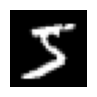

Image shape = torch.Size([28, 28])
label = 5


In [3]:
x, label = dataset[0]
image = x.reshape(28, 28)
plt.figure(figsize=(1, 1))
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()
print('Image shape =', image.shape)
print('label =', label)

## Models

In [4]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
        )
        self.mu = nn.Linear(hidden_dim, latent_dim)
        self.logvar = nn.Linear(hidden_dim, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
        )

        self.latent_dim = latent_dim

    def encode(self, x):
        x = self.encoder(x)
        return self.mu(x), self.logvar(x)

    def reparameterize(self, mu, logvar):
        eps = torch.randn_like(mu)
        sigma = torch.exp(0.5 * logvar)
        return mu + eps * sigma

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        logits = self.decode(z)
        return logits, mu, logvar

    def generate(self, n):
        device = next(self.parameters()).device
        z = torch.randn(n, self.latent_dim, device=device)
        with torch.no_grad():
            logits = self.decode(z)
        return F.sigmoid(logits)

## Training

In [5]:
def plot_loss(losses):
    display.clear_output(True)
    plt.figure(figsize=(6, 4))
    plt.plot(losses)
    plt.xlabel('Episode')
    plt.ylabel('Loss')
    plt.show()

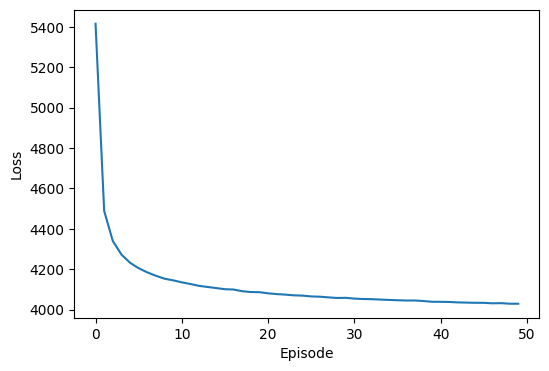

In [6]:
input_dim = 28*28
hidden_dim = 128
latent_dim = 16
batch_size = 32
learning_rate = 1e-3
epochs = 50

device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cuda")
model = VAE(input_dim, hidden_dim, latent_dim).to(device)
optimizer = Adam(model.parameters(), lr=learning_rate)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

def criterion(logits, x, mu, logvar):
    reconstruction = F.binary_cross_entropy_with_logits(logits, x, reduction='sum')
    kld = torch.sum(1 + logvar - mu ** 2 - torch.exp(logvar))
    return reconstruction - kld

losses = []
for epoch in range(epochs):
    epoch_losses = []
    for x, _ in dataloader:
        x = x.to(device)
        logits, mu, logvar = model(x)
        loss = criterion(logits, x, mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())

    loss = sum(epoch_losses) / len(epoch_losses)
    losses.append(loss)
    plot_loss(losses)

## Sampling

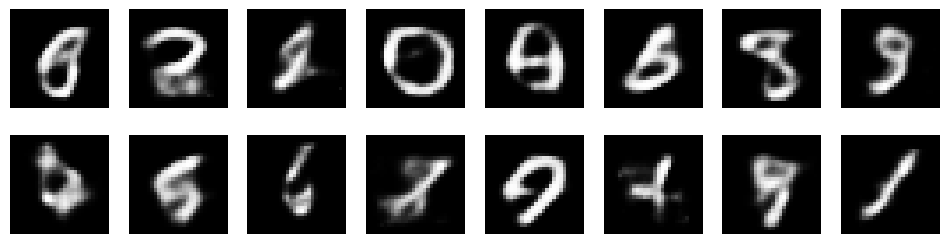

In [7]:
N = 16
x_hat = model.generate(N)
x_hat = x_hat.cpu().detach().numpy().reshape(-1, 28, 28)
images = [v2.functional.to_pil_image(x) for x in x_hat]

plt.figure(figsize=(12, 3))
for i, image in enumerate(images):
    plt.subplot(2, N//2, i+1)
    plt.imshow(image, cmap='gray')
    plt.axis('off')